In [6]:
import importlib
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install(libraries):
    for lib in libraries:
        try:
            importlib.import_module(lib)
            print(f"{lib} is already installed.")
        except ImportError:
            print(f"{lib} is not installed. Installing now...")
            install_package(lib)
            print(f"{lib} has been successfully installed.")

# List of libraries to check and install
libraries_to_check = ['stable_baselines3', 'torch', 'matplotlib', 'gdown', 'gymnasium', 'tqdm','rich']

check_and_install(libraries_to_check)

stable_baselines3 is already installed.
torch is already installed.
matplotlib is already installed.
gdown is already installed.
gymnasium is already installed.
tqdm is already installed.
rich is already installed.


In [7]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output
import matplotlib.colors as mcolors

import gymnasium as gym
import torch
import numpy as np
from collections import defaultdict
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure
tensorboard_log = './ppotb'
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Breeding Simulator

In [26]:
"""

This breeding simulation will simulate a single additive trait.

1) we will init a randomized population of size (config.starting_parents, 2, config.n_markers) with 0/1 tensor
2) we will use this starting population to sample the marker effects for our additive trait, which is scaled to be 0/1 mean/var for the population
3) we will store the founder_pop and their founder_phentypes

"""





## BREEDING SIMULATOR
    
class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, haplotypes:torch.tensor, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.haplotypes: torch.Tensor = haplotypes
        self.device: torch.device = device
        
    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"

class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        # Use torch.randn with a generator for reproducibility
        generator = torch.Generator(device=self.device)
        generator.manual_seed(torch.initial_seed())  # Use the seed set by torch.manual_seed()
        raw_effects = torch.randn(genome.n_markers, device=self.device, generator=generator)

        centered_effects = raw_effects - raw_effects.mean()
        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()

    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"


"""
The logic of the breeding simulation. Meiosis(Recombination) + Crossing

All operate on tensors
"""
@staticmethod
def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
    """ takes a tensor of parent genomes, (selected_haplotypes) and generates gametes for each parent"""
    num_parents, ploidy, num_markers = selected_haplotypes.shape

    # Repeat each parent's haplotypes num_gametes_per_parent times
    expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)

    # The rest of the function remains largely the same, but operates on the expanded haplotypes
    total_gametes = num_parents * num_gametes_per_parent

    crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device, generator=torch.Generator(device=selected_haplotypes.device).manual_seed(torch.initial_seed()))
    crossover_points, _ = torch.sort(crossover_points, dim=1)

    crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
    crossover_mask.scatter_(1, crossover_points, 1)
    crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1

    crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)

    start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
    start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)

    final_mask = crossover_mask ^ start_mask.bool()

    offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))

    # Return only the first haplotype for each meiosis event
    return offspring_haplotypes[:, 0, :]

@staticmethod
def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
    """ takes output from meiosis (gamete tensor) and outputs offspring """
    num_gametes, n_markers = gamete_tensor.shape

    # Double the gamete tensor until we have enough for the total crosses
    while num_gametes < 2 * total_crosses:
        gamete_tensor = torch.cat([gamete_tensor, gamete_tensor], dim=0)
        num_gametes *= 2

    # Randomly select gametes for crossing
    gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
    parent1_indices = gamete_indices[:total_crosses]
    parent2_indices = gamete_indices[total_crosses:2*total_crosses]

    # Create the new population haplotype tensor
    new_population = torch.stack([
        gamete_tensor[parent1_indices],
        gamete_tensor[parent2_indices]
    ], dim=1)

    return new_population
    
@staticmethod
def score_population(haplotypes: torch.Tensor, trait: Trait, h2: float = 1.0) -> torch.Tensor:
    dosages = haplotypes.sum(dim=1)
    breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)

    bv_var = breeding_values.var()
    if bv_var == 0 or h2 >= 1:
        return breeding_values, breeding_values

    env_variance = (1 - h2) / h2 * bv_var.item()
    env_std = torch.sqrt(torch.tensor(env_variance, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    env_effects = torch.randn_like(breeding_values) * env_std
    return breeding_values, breeding_values + env_effects + trait.intercept

class SimParams:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.genome = Genome(config.n_markers)

        # torch random 0/1 tensor of shaep (config.starting_parents, 2, config.n_markers)
        initial_haplotypes = torch.randint(0, 2, (config.starting_parents, 2, config.n_markers), device=self.device).float()
        self.founder_pop = Population(config.starting_parents, initial_haplotypes, self.genome, self.device)
        self.trait = Trait(self.genome, self.founder_pop)

import torch

def burn_in(SP, num_generations=20, h2=0.1, selection_intensity=0.2):
    current_pop = SP.founder_pop.haplotypes
    current_size = SP.config.starting_parents

    for generation in range(num_generations):
        # Expand population to desired size if necessary
        if current_size < SP.config.pop_size:
            gametes = meiosis(current_pop, num_gametes_per_parent=SP.config.pop_size // current_size + 1)
            current_pop = random_cross(gametes, total_crosses=SP.config.pop_size)
            current_size = SP.config.pop_size

        # Score the current population
        breeding_values, phenotypes = score_population(current_pop, SP.trait, h2=h2)

        # Select top individuals
        num_selected = max(int(current_size * selection_intensity), 2)  # Ensure at least 2 parents
        selection = torch.topk(phenotypes, num_selected).indices
        selected_parents = current_pop[selection]

        # Create next generation
        gametes = meiosis(selected_parents, num_gametes_per_parent=SP.config.pop_size // num_selected + 1)
        current_pop = random_cross(gametes, total_crosses=SP.config.pop_size)

        # Calculate genetic variance
        genetic_variance = breeding_values.var().item()

        if generation == num_generations-1:
            print(f"Generation {generation + 1}: "
                f"Max phenotype = {phenotypes.max().item():.4f}, "
                f"Max breeding value = {breeding_values.max().item():.4f}, "
                f"Genetic variance = {genetic_variance:.4f}")

    return current_pop




# example recurrent selection. first we make the f1 pop to go from number of starting parents to the fixed pop size
# founder_bv, founder_phenotypes = score_population(SP.founder_pop.haplotypes, SP.trait, h2=1)
# founder_gametes = meiosis(SP.founder_pop.haplotypes, num_gametes_per_parent = SP.config.pop_size)
# f1_pop = random_cross(founder_gametes, total_crosses= SP.config.pop_size)
# f1_bv, f1_phenotypes = score_population(f1_pop, SP.trait, h2=1)

# selection = torch.topk(f1_phenotypes, round(SP.config.pop_size * .1)).indices
# f2_parents = f1_pop[selection]
# f2_gametes = meiosis(f2_parents, num_gametes_per_parent=SP.config.pop_size)
# f2_pop = random_cross(f2_gametes, total_crosses=SP.config.pop_size)
# f2_bv, f2_phenotypes = score_population(f2_pop, SP.trait, h2=1)

# print(founder_phenotypes.max(), f1_phenotypes.max(), f2_phenotypes.max())


In [10]:
import numpy as np
import torch
from tqdm import tqdm

# Assuming you have already defined SimulationConfig, SimParams, and BreedingEnv

def evaluate_constant_action(env, action, num_episodes=10):
    total_reward = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            obs, reward, done, _, _ = env.step([action])
            episode_reward += reward
        total_reward += episode_reward
    return total_reward / num_episodes

def find_baseline(sim_params, max_generations=10, num_actions=20, num_episodes=10):
    env = BreedingEnv(sim_params, max_generations=max_generations)
    
    actions = np.linspace(0.01, 1.0, num_actions)
    results = []

    for action in tqdm(actions, desc="Evaluating actions"):
        avg_reward = evaluate_constant_action(env, action, num_episodes)
        results.append((action, avg_reward))

    best_action, best_reward = max(results, key=lambda x: x[1])
    return best_action, best_reward, results

def compare_max_generations(SP, max_generations_list, num_actions=20, num_episodes=10):
    results = {}
    
    for max_gen in tqdm(max_generations_list, desc="Evaluating max generations"):
        best_action, best_reward, all_results = find_baseline(SP, max_generations=max_gen, num_actions=num_actions, num_episodes=num_episodes)
        results[max_gen] = (best_action, best_reward, all_results)
    
    return results

@dataclass
class SimulationConfig:
    #training
    total_timesteps: int = 2000
    seed: int = 111
    #breeding sim parameters
    n_markers: int = 1000
    starting_parents: int = 20
    pop_size: int = 1000
    h2: float = 1.0
    max_generations:int = 25

# Run the burn-in
config = SimulationConfig()
config.seed = np.random.randint(100)
SP = SimParams(config)
burned_in_pop = burn_in(SP, num_generations=50, h2=0.50, selection_intensity=0.4)
# Update the SimParams with the burned-in population
SP.founder_pop = Population(config.pop_size, burned_in_pop, SP.genome, SP.device)
env = BreedingEnv(SP)
print("\nBurn-in complete.")
print(f"Final population size: {SP.founder_pop.haplotypes.shape[0]}")
# Find the baseline
best_action, best_reward, all_results = find_baseline(SP, max_generations=config.max_generations)

print(f"Best constant action: {best_action:.2f}")
print(f"Best average reward: {best_reward:.4f}")

# Plot the results
import matplotlib.pyplot as plt

actions, rewards = zip(*all_results)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000)

Generation 50: Max phenotype = 22.4773, Max breeding value = 16.3796, Genetic variance = 0.0650
torch.Size([1000, 2, 1000])

Burn-in complete.
Final population size: 1000
torch.Size([1000, 2, 1000])


Evaluating actions: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


Best constant action: 0.17
Best average reward: 3.4118
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 1.74     |
| time/              |          |
|    fps             | 409      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------


In [101]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch

class BreedingEnv(gym.Env):
    def __init__(self, sim_params: SimParams, max_generations: int = 10):
        super(BreedingEnv, self).__init__()
        
        self.SP = sim_params
        self.max_generations = max_generations
        self.current_generation = 0
        self.current_pop = self.SP.founder_pop.haplotypes
        self.selection_intensities = []

        # Define action and observation spaces
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            'remaining_generations': spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'genetic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
        })

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.current_pop = self.SP.founder_pop.haplotypes
        self.selection_intensities = []
        return self._get_obs(), {}

    def step(self, action):
        # Convert action to selection intensity
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01  # Maps [-1, 1] to [0.01, 0.99]
        self.selection_intensities.append(selection_intensity)
        
        # Score the current population
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        
        # Select top individuals
        num_selected = max(int(self.SP.config.pop_size * selection_intensity), 2)
        selection = torch.topk(phenotypes, num_selected).indices
        selected_parents = self.current_pop[selection]
        
        # Create next generation
        gametes = meiosis(selected_parents, num_gametes_per_parent=self.SP.config.pop_size // num_selected + 1)
        self.current_pop = random_cross(gametes, total_crosses=self.SP.config.pop_size)
        
        # Update generation count
        self.current_generation += 1
        
        # Calculate reward (e.g., improvement in max breeding value)
        new_breeding_values, new_phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        reward = new_breeding_values.max().item() - breeding_values.max().item()

        # Check if done
        done = self.current_generation >= self.max_generations

        # Prepare observation
        observation = self._get_obs()

        # Prepare info dictionary
        info = {
            'max_phenotype': new_phenotypes.max().item(),
            'current_generation': self.current_generation,
            'genetic_variance': observation[1]  # Assuming genetic_variance is the second element in observation
        }

        return observation, reward, done, False, info


    
    def _get_obs(self):
        breeding_values, _ = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        genetic_variance = breeding_values.var().item()
        remaining_generations = (self.max_generations - self.current_generation) / self.max_generations
        return {
            'remaining_generations': np.array([remaining_generations], dtype=np.float32),
            'genetic_variance': np.array([genetic_variance], dtype=np.float32)
            'current_generation': self.current_generation
        }

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3917033928.py, line 77)

In [126]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import defaultdict
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback




class GeneralizedVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0, log_freq=200, target_phenotype=None, best_action=None):
        super().__init__(verbose)
        self.data = defaultdict(lambda: defaultdict(list))
        self.log_freq = log_freq
        self.excluded_metrics = ['TimeLimit.truncated', 'current_generation']
        self.target_phenotype = target_phenotype
        self.best_action = best_action

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        obs = self.locals['new_obs']
        
        current_generation = info['current_generation']
        
        # Track all scalar values from the observation space
        for key, value in obs.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)
        
        # Also track any scalar values from the info dict
        for key, value in info.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)

        if self.num_timesteps % self.log_freq == 0:
            self.visualize()

        return True

    def visualize(self, window_size=10):
        num_metrics = len(self.data)
        fig, axes = plt.subplots(num_metrics, 1, figsize=(16, 6*num_metrics), sharex=True)
        if num_metrics == 1:
            axes = [axes]

        for idx, (metric, generations) in enumerate(self.data.items()):
            ax = axes[idx]
            num_generations = len(generations)
            colors = plt.cm.BuPu(np.linspace(0, 1, num_generations))

            for i, (generation, values) in enumerate(generations.items()):
                if len(values) == 0:
                    continue  # Skip empty data

                steps = np.arange(len(values))

                # Dynamically adjust window size
                effective_window = min(window_size, len(values))
                if effective_window < 2:
                    effective_window = 2  # Minimum window size

                # Calculate rolling moving average with adjusted window size
                rolling_avg = np.convolve(values, np.ones(effective_window), 'valid') / effective_window
                rolling_steps = steps[effective_window-1:]

                ax.plot(rolling_steps, rolling_avg, label=f'Generation {generation}', color=colors[i])
                ax.set_title(f'{metric.capitalize()} per Generation')
                ax.set_ylabel(f'Rolling Avg {metric.capitalize()}')
                ax.grid(True)

            # Add target_phenotype line for max_phenotype chart
            if metric == 'max_phenotype' and self.target_phenotype is not None:
                ax.axhline(y=self.target_phenotype, color='r', linestyle='--', label='Target Phenotype')

            # Add best_action line for selection_intensity chart
            if metric == 'selection_intensity' and self.best_action is not None:
                best_action_intensity = (self.best_action[0] + 1) / 2 * 0.98 + 0.01  # Convert to selection intensity
                ax.axhline(y=best_action_intensity, color='r', linestyle='--', label='Best Constant Action')

            # Set y-axis limits for selection_intensity
            if metric == 'selection_intensity':
                ax.set_ylim(0, 1)

            # Create a custom legend
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), 
                      bbox_to_anchor=(1.05, 0.5), 
                      loc='center left', 
                      fontsize='small')

        axes[-1].set_xlabel('Steps within Generation')
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

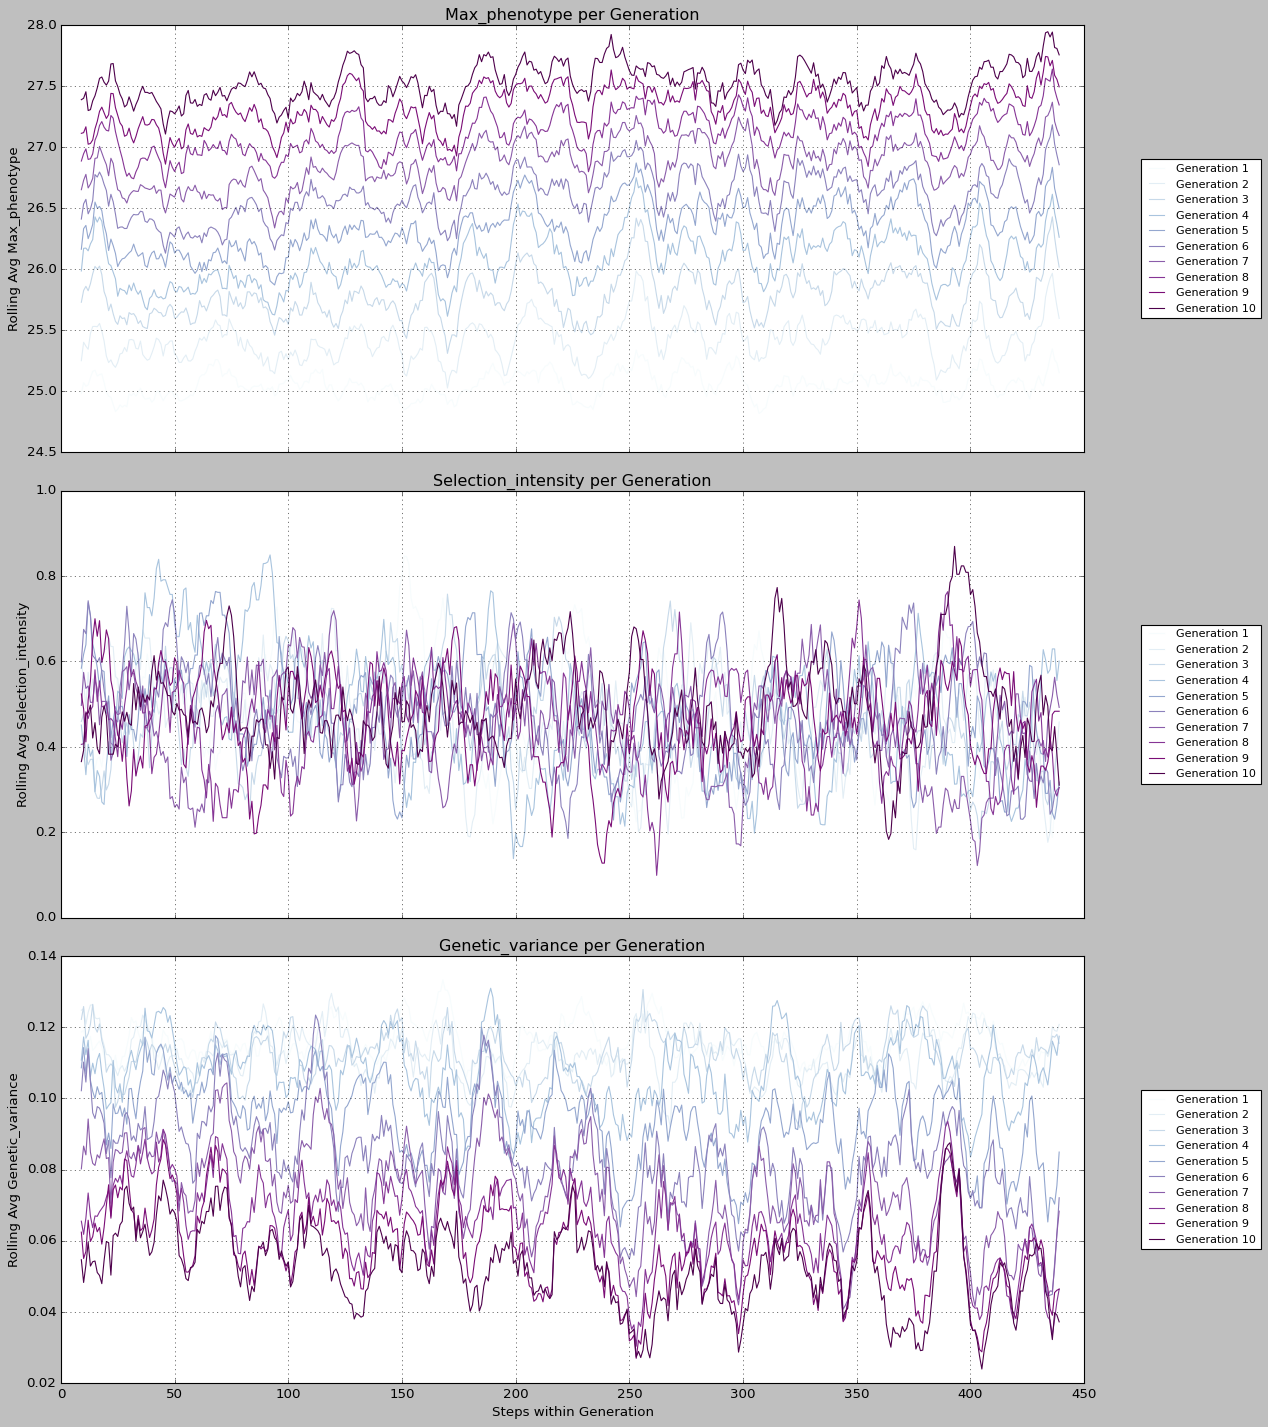

In [127]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

config = SimulationConfig()
config.seed = np.random.randint(100)
SP = SimParams(config)
burned_in_pop = burn_in(SP, num_generations=50, h2=0.50, selection_intensity=0.4)
# Update the SimParams with the burned-in population
SP.founder_pop = Population(config.pop_size, burned_in_pop, SP.genome, SP.device)
env = BreedingEnv(SP)

cb = GeneralizedVisualizationCallback()
# Create and train the model
model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=10000,callback=cb)

Evaluating max generations:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([1000, 2, 1000])


Evaluating max generations:  25%|██▌       | 1/4 [00:02<00:08,  2.96s/it]

torch.Size([1000, 2, 1000])


Evaluating max generations:  50%|█████     | 2/4 [00:08<00:09,  4.69s/it]

torch.Size([1000, 2, 1000])


Evaluating max generations:  75%|███████▌  | 3/4 [00:22<00:08,  8.94s/it]

torch.Size([1000, 2, 1000])


Evaluating max generations: 100%|██████████| 4/4 [00:51<00:00, 12.80s/it]


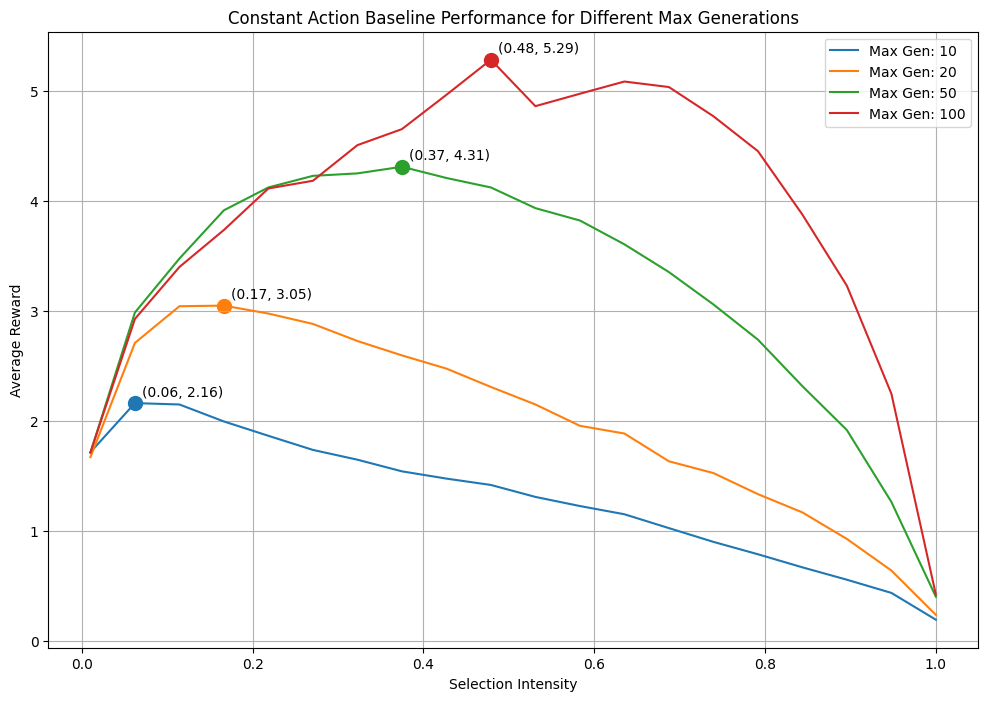

Max Generations: 10
Best constant action: 0.06
Best average reward: 2.1620

Max Generations: 20
Best constant action: 0.17
Best average reward: 3.0491

Max Generations: 50
Best constant action: 0.37
Best average reward: 4.3128

Max Generations: 100
Best constant action: 0.48
Best average reward: 5.2868



In [ ]:

# Define the max_generations values to compare
max_generations_list = [10, 20, 50, 100]

# Run the comparison
comparison_results = compare_max_generations(SP, max_generations_list)

# Plot the results
plt.figure(figsize=(12, 8))

for max_gen, (best_action, best_reward, all_results) in comparison_results.items():
    actions, rewards = zip(*all_results)
    plt.plot(actions, rewards, label=f'Max Gen: {max_gen}')
    plt.scatter(best_action, best_reward, marker='o', s=100)
    plt.annotate(f'({best_action:.2f}, {best_reward:.2f})', 
                 (best_action, best_reward), 
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('Selection Intensity')
plt.ylabel('Average Reward')
plt.title('Constant Action Baseline Performance for Different Max Generations')
plt.legend()
plt.grid(True)
plt.show()

# Print the best actions and rewards for each max_generations
for max_gen, (best_action, best_reward, _) in comparison_results.items():
    print(f"Max Generations: {max_gen}")
    print(f"Best constant action: {best_action:.2f}")
    print(f"Best average reward: {best_reward:.4f}")
    print()



In [14]:

# Example usage in a simple loop
obs, _ = env.reset()
for _ in range(100):
    action = env.action_space.sample()  # Replace with your RL agent's action
    obs, reward, done, _, _ = env.step(action)
    if done:
        break

# Environment